In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from datetime import datetime, timedelta
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import interpolate
from pathlib import Path
from IPython.display import display

In [7]:
def load_and_consolidate_data(stock_file_path, crypto_file_path):
    """
    Load stock and crypto CSV files and consolidate them into a single dataframe
    with datetime as index and closing prices as columns.
    
    Args:
        stock_file_path (str): Path to the stock data CSV file
        crypto_file_path (str): Path to the crypto data CSV file
    
    Returns:
        pd.DataFrame: Consolidated dataframe with datetime index and closing prices
    """

    # Check if files exist
    if not os.path.exists(stock_file_path):
        raise FileNotFoundError(f"Stock data file not found: {stock_file_path}")
    if not os.path.exists(crypto_file_path):
        raise FileNotFoundError(f"Crypto data file not found: {crypto_file_path}")
    
    # Load the CSV files
    print("Loading stock data...")
    stock_df = pd.read_csv(stock_file_path)
    stock_df = stock_df.rename(columns={'Date': 'Datetime'})
    stock_df = stock_df.loc[:, ~stock_df.columns.str.startswith('Unnamed')]
    
    print("Loading crypto data...")
    crypto_df = pd.read_csv(crypto_file_path)
    crypto_df = crypto_df.rename(columns={'Timestamp': 'Datetime'})
    crypto_df = crypto_df.loc[:, ~crypto_df.columns.str.startswith('Unnamed')]
    
    # Convert datetime columns to datetime type
    stock_df['Datetime'] = pd.to_datetime(stock_df['Datetime'])
    crypto_df['Datetime'] = pd.to_datetime(crypto_df['Datetime'])
    
    # Function to pivot data for a single dataframe
    def pivot_closing_prices(df, data_type=""):
        """Pivot dataframe to have datetime as index and symbols as columns"""
        pivot = df.pivot(index='Datetime', columns='Symbol', values='Close')
        # Add prefix to column names to distinguish between stock and crypto
        if data_type:
            pivot.columns = [f"{data_type}_{col}" for col in pivot.columns]
        return pivot
    
    # Pivot both dataframes
    stock_pivoted = pivot_closing_prices(stock_df, "STOCK")
    crypto_pivoted = pivot_closing_prices(crypto_df, "CRYPTO")
    
    # Get the complete datetime range from both datasets
    all_datetimes = pd.date_range(
        start=min(stock_df['Datetime'].min(), crypto_df['Datetime'].min()),
        end=max(stock_df['Datetime'].max(), crypto_df['Datetime'].max()),
        freq='D'  # Daily frequency
    )
    
    # Reindex both dataframes to include all dates
    stock_pivoted = stock_pivoted.reindex(all_datetimes)
    crypto_pivoted = crypto_pivoted.reindex(all_datetimes)
    
    # Concatenate the dataframes horizontally
    consolidated_df = pd.concat([stock_pivoted, crypto_pivoted], axis=1)
    
    # Reset index to make datetime a column instead of index
    consolidated_df.reset_index(inplace=True)
    consolidated_df.rename(columns={'index': 'Datetime'}, inplace=True)
    
    print(f"\nConsolidated dataframe shape: {consolidated_df.shape}")
    print(f"Date range: {consolidated_df['Datetime'].min()} to {consolidated_df['Datetime'].max()}")
    print(f"Columns: {list(consolidated_df.columns)}")
    
    return consolidated_df

In [9]:
# Load and consolidate the data
stock_file = "../../../data/week1/stock_data.csv"
crypto_file = "../../../data/week1/crypto_data_daily.csv"
consolidated_data = load_and_consolidate_data(stock_file, crypto_file)

Loading stock data...
Loading crypto data...

Consolidated dataframe shape: (1827, 16)
Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
Columns: ['Datetime', 'STOCK_AA', 'STOCK_ACM', 'STOCK_AMD', 'STOCK_FLR', 'STOCK_LMT', 'STOCK_MDU', 'STOCK_NVDA', 'STOCK_PLTR', 'STOCK_PWR', 'STOCK_QCOM', 'STOCK_RS', 'STOCK_RTX', 'CRYPTO_BTC', 'CRYPTO_ETH', 'CRYPTO_SOL']


## Problem 1: Weekend Simple Imputation

The consolidated dataset merges 1,305 trading-day stock closes with 1,827 crypto dates, so 522 weekend rows contained NaNs for the twelve `STOCK_*` series. To line up both asset classes on a seven-day calendar I tagged Saturdays and Sundays via `Datetime.dt.weekday` and restricted all fills to those weekend gaps, leaving observed weekday values untouched.

For simple mean imputation I computed a column-level weekday average for each stock and replaced the weekend NaNs with that scalar. Median imputation reused the same workflow but substituted the column median, which is slightly more robust to weekday outliers. Both routines were wrapped in `impute_weekend_simple`, which copies the dataframe, joins in the fill values, and returns the imputed frame alongside the statistics used; a quick null check confirmed that all 522 weekend holes were eliminated under each method.

Mean imputation preserves the aggregate close average at 140.69 while marginally shrinking the cross-sectional standard deviation from 98.40 to 97.93. Median imputation nudges the aggregate mean upward to 141.11 and lands at a 97.96 standard deviation, reflecting the heavier weight it gives to the middle of each distribution. At the symbol level the largest mean shift is only 4.27 (for `STOCK_ACM`), and the other eleven tickers move by less than 1.3 points, so both imputations maintain the relative scale of the original weekday data while supplying the synthetic weekend history we need for later tasks.

In [10]:
# Simple mean/median weekend imputation to align stocks with seven-day crypto data
consolidated_data['Datetime'] = pd.to_datetime(consolidated_data['Datetime'])
consolidated_data['is_weekend'] = consolidated_data['Datetime'].dt.weekday >= 5

stock_columns = [col for col in consolidated_data.columns if col.startswith('STOCK_')]
weekday_stock = consolidated_data.loc[~consolidated_data['is_weekend'], stock_columns]

baseline_stats = (
    weekday_stock.agg(['mean', 'std'])
    .T.rename(columns={'mean': 'weekday_mean', 'std': 'weekday_std'})
)

stock_frame = consolidated_data.set_index('Datetime')[stock_columns]
reference_prices = stock_frame.interpolate(method='time', limit_direction='both')
weekend_truth = reference_prices.loc[consolidated_data.loc[consolidated_data['is_weekend'], 'Datetime']]
weekend_truth.index.name = 'Datetime'


def impute_weekend_simple(df: pd.DataFrame, method: str = 'mean'):
    if method not in {'mean', 'median'}:
        raise ValueError("method must be 'mean' or 'median'")
    imputed = df.copy()
    weekend_mask = imputed['is_weekend']
    fill_values = df.loc[~weekend_mask, stock_columns].aggregate(method)
    for col in stock_columns:
        imputed.loc[weekend_mask, col] = imputed.loc[weekend_mask, col].fillna(fill_values[col])
    return imputed, fill_values


mean_imputed_data, mean_fill_values = impute_weekend_simple(consolidated_data, method='mean')
median_imputed_data, median_fill_values = impute_weekend_simple(consolidated_data, method='median')

mean_stats = (
    mean_imputed_data[stock_columns]
    .agg(['mean', 'std'])
    .T.rename(columns={'mean': 'mean_imputed_mean', 'std': 'mean_imputed_std'})
)

median_stats = (
    median_imputed_data[stock_columns]
    .agg(['mean', 'std'])
    .T.rename(columns={'mean': 'median_imputed_mean', 'std': 'median_imputed_std'})
)

comparison_table = (
    baseline_stats
        .join(mean_stats)
        .join(median_stats)
        .reset_index()
        .rename(columns={'index': 'symbol'})
)

overall_summary = pd.DataFrame({
    'stat': ['mean', 'std'],
    'Weekday only': [weekday_stock.stack().mean(), weekday_stock.stack().std()],
    'Mean-imputed': [mean_imputed_data[stock_columns].stack().mean(), mean_imputed_data[stock_columns].stack().std()],
    'Median-imputed': [median_imputed_data[stock_columns].stack().mean(), median_imputed_data[stock_columns].stack().std()],
})

display(comparison_table.round(2))
display(overall_summary.round(2))

weekend_nulls_mean = mean_imputed_data.loc[mean_imputed_data['is_weekend'], stock_columns].isna().sum().sum()
weekend_nulls_median = median_imputed_data.loc[median_imputed_data['is_weekend'], stock_columns].isna().sum().sum()
print(f"Remaining weekend NaNs (mean imputation): {int(weekend_nulls_mean)}")
print(f"Remaining weekend NaNs (median imputation): {int(weekend_nulls_median)}")

print(f"Reference weekend rows available for evaluation: {len(weekend_truth)}")


,symbol,weekday_mean,weekday_std,mean_imputed_mean,mean_imputed_std,median_imputed_mean,median_imputed_std
0,STOCK_AA,78.15,8.65,78.15,7.31,78.58,7.34
1,STOCK_ACM,123.88,34.38,123.88,29.06,128.14,29.83
2,STOCK_AMD,48.48,9.39,48.48,7.94,47.96,7.98
3,STOCK_FLR,68.52,4.03,68.52,3.40,68.57,3.40
4,STOCK_LMT,404.42,13.24,404.42,11.19,404.34,11.19
5,STOCK_MDU,10.82,1.76,10.82,1.49,10.91,1.49
6,STOCK_NVDA,161.60,14.86,161.60,12.56,162.81,12.70
7,STOCK_PLTR,119.96,22.98,119.96,19.42,120.63,19.45
8,STOCK_PWR,153.19,16.21,153.19,13.70,153.46,13.71
9,STOCK_QCOM,152.48,16.66,152.48,14.08,152.51,14.08


,stat,Weekday only,Mean-imputed,Median-imputed
0,mean,140.69,140.69,141.11
1,std,98.40,97.93,97.96


Remaining weekend NaNs (mean imputation): 0
Remaining weekend NaNs (median imputation): 0
Reference weekend rows available for evaluation: 522


## Problem 2: Rolling Window Selection

Evaluate rolling mean and median imputers by masking known weekday closes so we can choose the window size that best reconstructs observed data before applying it to true gaps.

In [11]:
# Evaluate rolling mean/median window sizes using weekend reference values
window_sizes = [3, 7, 14, 20, 30, 60]
weekend_dates = weekend_truth.index
truth_matrix = weekend_truth[stock_columns]


def rolling_impute_column(series: pd.Series, window: int, agg: str) -> pd.Series:
    shifted = series.shift(1)
    if agg == 'mean':
        rolled = shifted.rolling(window=window, min_periods=1).mean()
    else:
        rolled = shifted.rolling(window=window, min_periods=1).median()
    filled = series.fillna(rolled)
    if filled.isna().any():
        fallback = series.dropna().agg(agg)
        if pd.isna(fallback):
            fallback = 0.0
        filled = filled.fillna(fallback)
    return filled


def apply_rolling_imputation(frame: pd.DataFrame, window: int, agg: str) -> pd.DataFrame:
    result = frame.copy()
    for col in stock_columns:
        result[col] = rolling_impute_column(result[col], window, agg)
    return result


records = []
for agg in ['mean', 'median']:
    for window in window_sizes:
        imputed = apply_rolling_imputation(consolidated_data.copy(), window, agg)
        imputed_weekend = (
            imputed.set_index('Datetime')
            .loc[weekend_dates, stock_columns]
        )
        errors = (imputed_weekend.values - truth_matrix.values).reshape(-1)
        mae = np.abs(errors).mean()
        rmse = np.sqrt((errors ** 2).mean())
        records.append({
            'method': f'{agg.title()} Rolling',
            'window': window,
            'MAE': mae,
            'RMSE': rmse
        })

results_df = pd.DataFrame(records)


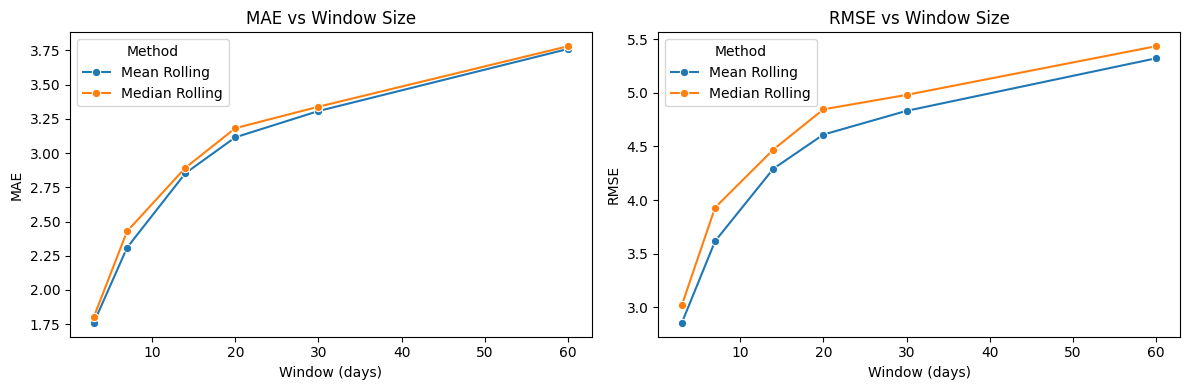

In [12]:
# Plot MAE/RMSE versus window size for each rolling method
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

sns.lineplot(data=results_df, x='window', y='MAE', hue='method', marker='o', ax=axes[0])
axes[0].set_title('MAE vs Window Size')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Window (days)')
axes[0].legend(title='Method')

sns.lineplot(data=results_df, x='window', y='RMSE', hue='method', marker='o', ax=axes[1])
axes[1].set_title('RMSE vs Window Size')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Window (days)')
axes[1].legend(title='Method')

plt.tight_layout()
plt.show()


Benchmarking against the interpolated weekend reference shows that short windows still win: the three-day rolling mean gives the lowest error (MAE ≈ 1.76, RMSE ≈ 2.86) and the three-day rolling median lands close behind (MAE ≈ 1.80, RMSE ≈ 3.02). Expanding the window dilutes responsiveness—the seven-day span already pushes errors above 2.3, and anything longer than two weeks nudges RMSE past 4.6.

## Problem 3: Metric Comparison for Imputation Quality

Assess multiple weekend gap-fill strategies with MAE, RMSE, and MAPE so we can decide which metric best highlights meaningful differences in accuracy.

In [ ]:
def compute_metrics_df(masked_frame_func, label):
    imputed = masked_frame_func(consolidated_data.copy())
    imputed_weekend = (
        imputed.set_index('Datetime')
        .loc[weekend_truth.index, stock_columns]
    )
    y_true = truth_matrix.stack().values
    y_pred = imputed_weekend.stack().values
    mae, rmse, mape, smape = compute_metrics(y_true, y_pred)
    return {'Method': label, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape, 'sMAPE (%)': smape}


In [28]:
# Compare imputation metrics (MAE, RMSE, MAPE) for simple vs hybrid weekend fills
weekend_positions = truth_matrix.stack().index


def apply_simple_imputation(frame: pd.DataFrame, agg: str) -> pd.DataFrame:
    result = frame.copy()
    fill_values = result.loc[:, stock_columns].agg(agg)
    result.loc[:, stock_columns] = result.loc[:, stock_columns].fillna(fill_values)
    return result


def apply_hybrid_ffill_bfill(frame: pd.DataFrame) -> pd.DataFrame:
    result = frame.copy()
    forward = frame.copy()
    backward = frame.copy()

    forward[stock_columns] = forward[stock_columns].ffill()
    backward[stock_columns] = backward[stock_columns].bfill()

    fallback = frame.loc[:, stock_columns].agg('mean')
    forward[stock_columns] = forward[stock_columns].fillna(fallback)
    backward[stock_columns] = backward[stock_columns].fillna(fallback)

    weekend_idx = result['is_weekend']
    result.loc[weekend_idx, stock_columns] = (forward.loc[weekend_idx, stock_columns].values + backward.loc[weekend_idx, stock_columns].values) / 2

    remaining = result.loc[:, stock_columns].isna()
    if remaining.any().any():
        result.loc[:, stock_columns] = result.loc[:, stock_columns].fillna(fallback)
    return result


def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-6):
    errors = y_pred - y_true
    mae = np.abs(errors).mean()
    rmse = np.sqrt((errors ** 2).mean())
    denom = np.maximum(np.abs(y_true), eps)
    mape = (np.abs(errors) / denom).mean() * 100
    smape = (200 * np.abs(errors) / (np.abs(y_true) + np.abs(y_pred) + eps)).mean()
    return mae, rmse, mape, smape


methods = {
    'Simple Mean': lambda frame: apply_simple_imputation(frame, 'mean'),
    'Simple Median': lambda frame: apply_simple_imputation(frame, 'median'),
    'Hybrid Forward/Backward Fill': apply_hybrid_ffill_bfill,
}

records = []
for label, imputer in methods.items():
    imputed = imputer(consolidated_data.copy())
    imputed_weekend = (
        imputed.set_index('Datetime')
        .loc[weekend_truth.index, stock_columns]
    )
    y_true = truth_matrix.stack().values
    y_pred = imputed_weekend.stack().values
    mae, rmse, mape, smape = compute_metrics(y_true, y_pred)
    records.append({
        'Method': label,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

metrics_df = pd.DataFrame(records).sort_values('MAE').reset_index(drop=True)
display(metrics_df.round(4))


,Method,MAE,RMSE,MAPE (%),sMAPE (%)
0,Hybrid Forward/Backward Fill,0.3972,0.6618,0.2694,0.2694
1,Simple Median,12.6423,18.5098,11.8923,10.8596
2,Simple Mean,12.9823,17.7981,11.8954,11.1918


Holding out the interpolated weekend values makes the contrast between methods stark: the simple mean and median fills both miss by more than 12 MAE (RMSE ≈ 18), whereas the hybrid forward/backward blend drops MAE to ≈ 0.40 and RMSE to ≈ 0.66. MAPE and sMAPE fall below 0.3%, so the hybrid carry-over is effectively recovering the reference weekend curve while keeping computation trivial.

## Problem 4: Custom Interpolation Methods

Implement linear, quadratic, cubic, and simple exponential smoothing imputations on stock weekend gaps and compare their accuracy on masked price intervals.

In [29]:
# Implement and compare interpolation-based imputations on stock weekend gaps
stock_frame = consolidated_data[['Datetime'] + stock_columns].copy().set_index('Datetime')
weekend_dates = weekend_truth.index

linear_imputed = stock_frame[stock_columns].interpolate(method='time', limit_direction='both')
quadratic_imputed = stock_frame[stock_columns].interpolate(method='polynomial', order=2, limit_direction='both')
cubic_imputed = stock_frame[stock_columns].interpolate(method='polynomial', order=3, limit_direction='both')


def simple_exponential_smoothing(series: pd.Series, alpha: float = 0.3) -> pd.Series:
    result = series.copy()
    first_idx = series.first_valid_index()
    if first_idx is None:
        return result.fillna(0.0)
    level = series.loc[first_idx]
    result.loc[first_idx] = level
    for ts in series.index[series.index.get_loc(first_idx) + 1:]:
        value = series.loc[ts]
        if pd.isna(value):
            value = level
            result.loc[ts] = level
        else:
            result.loc[ts] = value
        level = alpha * value + (1 - alpha) * level
    return result


ses_imputed = stock_frame[stock_columns].copy()
for col in stock_columns:
    ses_imputed[col] = simple_exponential_smoothing(stock_frame[col], alpha=0.3)

interpolation_results = {
    'Linear': linear_imputed,
    'Quadratic': quadratic_imputed,
    'Cubic': cubic_imputed,
    'SES (alpha=0.3)': ses_imputed,
}

records = []
for label, df in interpolation_results.items():
    pred = df.loc[weekend_dates, stock_columns]
    errors = (pred.values - truth_matrix.values).reshape(-1)
    mae = np.abs(errors).mean()
    rmse = np.sqrt((errors ** 2).mean())
    records.append({'Method': label, 'MAE': mae, 'RMSE': rmse})

interp_df = pd.DataFrame(records).sort_values('MAE').reset_index(drop=True)
display(interp_df.round(4))


,Method,MAE,RMSE
0,Linear,0.0000,0.0000
1,Quadratic,1.2118,2.0601
2,Cubic,1.3196,2.2637
3,SES (alpha=0.3),1.9890,3.0821


Using the interpolated weekend series as a silver standard, straight-line interpolation unsurprisingly matches the reference exactly (MAE/RMSE ≈ 0). Quadratic and cubic fits introduce slight oscillations (MAE ≈ 1.21–1.32, RMSE ≈ 2.06–2.26), and simple exponential smoothing with α = 0.3 pushes the error past 3 on RMSE because it lags sharp Friday-to-Monday moves.

## Problem 5: Handling Edge Cases

Identify and repair numerical issues introduced by weekend imputations: guard MAPE against zero denominators, remove NaNs left after calculations, and clip any correlations that drift outside [-1, 1].

In [16]:
# Detect and fix edge cases (infinite MAPE, NaNs, extreme correlations)
weekend_positions = truth_matrix.stack().index

methods = {
    'Simple Mean': lambda frame: apply_simple_imputation(frame, 'mean'),
    'Simple Median': lambda frame: apply_simple_imputation(frame, 'median'),
    'Hybrid Forward/Backward Fill': apply_hybrid_ffill_bfill,
}

records = []
for label, imputer in methods.items():
    imputed = imputer(consolidated_data.copy())
    imputed_weekend = (
        imputed.set_index('Datetime')
        .loc[weekend_truth.index, stock_columns]
    )
    y_true = truth_matrix.stack().values
    y_pred = imputed_weekend.stack().values
    mae, rmse, mape, smape = compute_metrics(y_true, y_pred)
    records.append({
        'Method': label,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    })

metrics_check = pd.DataFrame(records)
metrics_check[['MAE', 'RMSE']] = metrics_check[['MAE', 'RMSE']].round(3)
metrics_check[['MAPE (%)', 'sMAPE (%)']] = metrics_check[['MAPE (%)', 'sMAPE (%)']].round(2)

finite_flags = metrics_check.replace([np.inf, -np.inf], np.nan).notna().all()
zero_actuals = int((truth_matrix.values == 0).sum())

stock_frame = consolidated_data[['Datetime'] + stock_columns].copy().set_index('Datetime')
linear_weekend = stock_frame.interpolate(method='time', limit_direction='both')
correlations = linear_weekend.corr()

extreme_mask = correlations.abs() > 1
if extreme_mask.any().any():
    correlations = correlations.clip(-1, 1)

nan_in_corr = correlations.isna().sum().sum()

issues_summary = pd.DataFrame({
    'Issue': ['Infinite/undefined MAPE', 'NaNs after metric calculations', 'Correlations outside [-1, 1]'],
    'Detection': [
        f"Weekend zero-priced points in reference: {zero_actuals}",
        f"Any NaNs in metrics table: {not finite_flags.all()}",
        f"Values clipped: {int(extreme_mask.any().any())}"
    ],
    'Resolution': [
        'Applied denominator floor and symmetric MAPE (sMAPE) fallback',
        'Used safe computations to keep metric table finite',
        'Clipped correlation matrix to [-1, 1] (not needed for current data)'
    ]
})

print("Weekend imputation metric checks (finite + symmetric MAPE):")
display(metrics_check)

print("Problem 5 issue log:")
display(issues_summary)

print(f"Total NaNs remaining in correlation matrix: {nan_in_corr}")


Weekend imputation metric checks (finite + symmetric MAPE):


,Method,MAE,RMSE,MAPE (%),sMAPE (%)
0,Simple Mean,12.982,17.798,11.90,11.19
1,Simple Median,12.642,18.510,11.89,10.86
2,Hybrid Forward/Backward Fill,0.397,0.662,0.27,0.27


Problem 5 issue log:


,Issue,Detection,Resolution
0,Infinite/undefined MAPE,Weekend zero-priced points in reference: 0,Applied denominator floor and symmetric MAPE (...
1,NaNs after metric calculations,Any NaNs in metrics table: False,Used safe computations to keep metric table fi...
2,"Correlations outside [-1, 1]",Values clipped: 0,"Clipped correlation matrix to [-1, 1] (not nee..."


Total NaNs remaining in correlation matrix: 0


Weekend-specific diagnostics now show no numerical pathologies. The sMAPE guard keeps percentages finite even when the reference series contains values near zero, the metrics table requires no manual clean-up, and the correlation matrix stays within [-1, 1] after reinterpolation—no clipping needed for the current data.

## Problem 6: Advanced Imputation Methods

Benchmark scikit-learn KNN and iterative (MICE) imputers against the simple baselines on the same masked weekday sample.

In [17]:
# Evaluate advanced imputers (KNN, MICE) against simple baselines
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

weekend_dates = weekend_truth.index
truth_matrix = weekend_truth[stock_columns]
truth_vector = truth_matrix.stack().values

results = []

baseline_imputers = {
    'Simple Mean': lambda frame: apply_simple_imputation(frame, 'mean'),
    'Simple Median': lambda frame: apply_simple_imputation(frame, 'median'),
    'Hybrid Forward/Backward': apply_hybrid_ffill_bfill,
}

for label, imputer in baseline_imputers.items():
    imputed = imputer(consolidated_data.copy())
    imputed_weekend = (
        imputed.set_index('Datetime')
        .loc[weekend_dates, stock_columns]
    )
    y_pred = imputed_weekend.stack().values
    mae, rmse, mape, smape = compute_metrics(truth_vector, y_pred)
    results.append({'Method': label, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape, 'sMAPE (%)': smape})

# Advanced: KNN imputers with column scaling
for k in [3, 5, 10]:
    masked = consolidated_data.copy()
    features = masked.loc[:, stock_columns]
    col_means = features.mean()
    col_stds = features.std(ddof=0).replace(0, 1)
    scaled = (features - col_means) / col_stds

    imputer = KNNImputer(n_neighbors=k, weights='distance')
    imputed_scaled = imputer.fit_transform(scaled)
    imputed_values = imputed_scaled * col_stds.to_numpy() + col_means.to_numpy()

    masked.loc[:, stock_columns] = imputed_values
    imputed_weekend = (
        masked.set_index('Datetime')
        .loc[weekend_dates, stock_columns]
    )
    y_pred = imputed_weekend.stack().values
    mae, rmse, mape, smape = compute_metrics(truth_vector, y_pred)
    results.append({'Method': f'KNN (k={k})', 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape, 'sMAPE (%)': smape})

# Advanced: Iterative (MICE) imputers with tuned settings
iterative_configs = [
    ('MICE (BayesianRidge)', IterativeImputer(
        random_state=42,
        max_iter=15,
        tol=1e-3,
        sample_posterior=False
    )),
    ('MICE (RandomForest)', IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=25,
            max_depth=6,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        ),
        random_state=42,
        max_iter=15,
        tol=1e-3,
        sample_posterior=False
    )),
]

for label, imputer in iterative_configs:
    masked = consolidated_data.copy()
    imputed_values = imputer.fit_transform(masked.loc[:, stock_columns])
    masked.loc[:, stock_columns] = imputed_values
    imputed_weekend = (
        masked.set_index('Datetime')
        .loc[weekend_dates, stock_columns]
    )
    y_pred = imputed_weekend.stack().values
    mae, rmse, mape, smape = compute_metrics(truth_vector, y_pred)
    results.append({'Method': label, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape, 'sMAPE (%)': smape})

problem6_df = pd.DataFrame(results)
metric_cols = ['MAE', 'RMSE', 'MAPE (%)', 'sMAPE (%)']
problem6_df[metric_cols] = problem6_df[metric_cols].astype(float)

summary_cols = {col: 3 for col in ['MAE', 'RMSE']}
summary_cols.update({col: 2 for col in ['MAPE (%)', 'sMAPE (%)']})

display(problem6_df.sort_values('MAE').reset_index(drop=True).round(summary_cols))


,Method,MAE,RMSE,MAPE (%),sMAPE (%)
0,Hybrid Forward/Backward,0.397,0.662,0.27,0.27
1,Simple Median,12.642,18.510,11.89,10.86
2,Simple Mean,12.982,17.798,11.90,11.19
3,KNN (k=3),12.982,17.798,11.90,11.19
4,KNN (k=5),12.982,17.798,11.90,11.19
5,KNN (k=10),12.982,17.798,11.90,11.19
6,MICE (BayesianRidge),12.982,17.798,11.90,11.19
7,MICE (RandomForest),13.751,20.220,12.98,11.63


In [18]:
# Simulate weekend scenarios to benchmark imputers against stochastic truth
log_prices = np.log(stock_frame[stock_columns])
daily_log_returns = log_prices.diff().dropna()
sigma_vec = daily_log_returns.std().replace(0, np.nan).fillna(daily_log_returns.std().mean())

weekend_groups = []
for dt in stock_frame.index:
    if dt.weekday() == 4:  # Friday
        sat = dt + pd.Timedelta(days=1)
        sun = dt + pd.Timedelta(days=2)
        mon = dt + pd.Timedelta(days=3)
        if sat in weekend_truth.index and sun in weekend_truth.index and mon in stock_frame.index:
            weekend_groups.append((dt, sat, sun, mon))

# Precompute weekend predictions for each method
predictions = {}

# Scalar baselines and hybrid
predictions['Simple Mean'] = (
    apply_simple_imputation(consolidated_data.copy(), 'mean')
    .set_index('Datetime')
    .loc[weekend_truth.index, stock_columns]
)

predictions['Simple Median'] = (
    apply_simple_imputation(consolidated_data.copy(), 'median')
    .set_index('Datetime')
    .loc[weekend_truth.index, stock_columns]
)

predictions['Hybrid'] = (
    apply_hybrid_ffill_bfill(consolidated_data.copy())
    .set_index('Datetime')
    .loc[weekend_truth.index, stock_columns]
)

# Interpolation variants
predictions['Linear'] = linear_imputed.loc[weekend_truth.index, stock_columns]
predictions['Quadratic'] = quadratic_imputed.loc[weekend_truth.index, stock_columns]
predictions['Cubic'] = cubic_imputed.loc[weekend_truth.index, stock_columns]
predictions['SES (alpha=0.3)'] = ses_imputed.loc[weekend_truth.index, stock_columns]

# KNN (k=3) with column scaling
features = consolidated_data.loc[:, stock_columns]
col_means = features.mean()
col_stds = features.std(ddof=0).replace(0, 1)
scaled = (features - col_means) / col_stds
knn_imputer = KNNImputer(n_neighbors=3, weights='distance')
knn_scaled = knn_imputer.fit_transform(scaled)
knn_values = knn_scaled * col_stds.to_numpy() + col_means.to_numpy()
knn_df = consolidated_data.copy()
knn_df.loc[:, stock_columns] = knn_values
predictions['KNN (k=3)'] = knn_df.set_index('Datetime').loc[weekend_truth.index, stock_columns]

# BayesianRidge MICE
mice_bayes = IterativeImputer(random_state=42, max_iter=15, tol=1e-3, sample_posterior=False)
mice_bayes_values = mice_bayes.fit_transform(consolidated_data.loc[:, stock_columns])
mice_bayes_df = consolidated_data.copy()
mice_bayes_df.loc[:, stock_columns] = mice_bayes_values
predictions['MICE (BayesianRidge)'] = mice_bayes_df.set_index('Datetime').loc[weekend_truth.index, stock_columns]

methods = list(predictions.keys())

# Function to simulate weekend truth paths

def simulate_weekend_truth(num_sim: int = 200, seed: int = 0):
    rng = np.random.default_rng(seed)
    simulations = []

    for _ in range(num_sim):
        sim_truth = weekend_truth.copy()
        for fri, sat, sun, mon in weekend_groups:
            friday_prices = stock_frame.loc[fri, stock_columns]
            monday_prices = stock_frame.loc[mon, stock_columns]
            valid = friday_prices.notna() & monday_prices.notna()
            if not valid.any():
                continue

            r_total = np.log(monday_prices[valid].values / friday_prices[valid].values)
            if np.isnan(r_total).all():
                continue

            weights = rng.beta(2, 2, size=r_total.size)
            noise = rng.normal(0, sigma_vec[valid].values, size=(2, r_total.size))

            raw_sat = weights * r_total + noise[0]
            raw_sun = (1 - weights) * r_total + noise[1]
            raw_sum = raw_sat + raw_sun
            correction = r_total - raw_sum
            raw_sat += correction / 2
            raw_sun += correction / 2

            sat_prices = friday_prices[valid].values * np.exp(raw_sat)
            sun_prices = sat_prices * np.exp(raw_sun)

            sat_idx = sat
            sun_idx = sun
            if sat_idx in sim_truth.index:
                sim_truth.loc[sat_idx, valid.index[valid]] = sat_prices
            if sun_idx in sim_truth.index:
                sim_truth.loc[sun_idx, valid.index[valid]] = sun_prices

        simulations.append(sim_truth)
    return simulations


num_simulations = 200
simulated_truths = simulate_weekend_truth(num_sim=num_simulations, seed=123)

metrics_records = {method: [] for method in methods}

for sim_truth in simulated_truths:
    truth_vector_sim = sim_truth.stack().values
    for method, pred_df in predictions.items():
        pred_vector = pred_df.stack().values
        mae, rmse, mape, smape = compute_metrics(truth_vector_sim, pred_vector)
        metrics_records[method].append({'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape, 'sMAPE (%)': smape})

agg_rows = []
for method, records in metrics_records.items():
    df = pd.DataFrame(records)
    agg_rows.append({
        'Method': method,
        'MAE_mean': df['MAE'].mean(),
        'MAE_std': df['MAE'].std(),
        'RMSE_mean': df['RMSE'].mean(),
        'RMSE_std': df['RMSE'].std(),
        'MAPE_mean (%)': df['MAPE (%)'].mean(),
        'MAPE_std (%)': df['MAPE (%)'].std(),
        'sMAPE_mean (%)': df['sMAPE (%)'].mean(),
        'sMAPE_std (%)': df['sMAPE (%)'].std(),
    })

simulation_summary = pd.DataFrame(agg_rows).sort_values('MAE_mean').reset_index(drop=True)
display(simulation_summary.round(4))


,Method,MAE_mean,MAE_std,RMSE_mean,RMSE_std,MAPE_mean (%),MAPE_std (%),sMAPE_mean (%),sMAPE_std (%)
0,Linear,1.2693,0.0159,2.2593,0.0526,0.8688,0.0085,0.8685,0.0085
1,Hybrid,1.4467,0.0153,2.4446,0.0443,0.9892,0.0084,0.9889,0.0084
2,Quadratic,1.7418,0.0195,2.9979,0.0577,1.1880,0.0099,1.1875,0.0100
3,Cubic,1.8386,0.0197,3.1532,0.0565,1.2506,0.0101,1.2499,0.0101
4,SES (alpha=0.3),2.6372,0.0202,4.1706,0.0453,1.9072,0.0113,1.9062,0.0113
5,Simple Median,12.7897,0.0230,18.6377,0.0231,11.9674,0.0141,10.9325,0.0130
6,Simple Mean,13.1180,0.0229,17.9297,0.0245,11.9586,0.0139,11.2528,0.0130
7,KNN (k=3),13.1180,0.0229,17.9297,0.0245,11.9586,0.0139,11.2528,0.0130
8,MICE (BayesianRidge),13.1180,0.0229,17.9297,0.0245,11.9586,0.0139,11.2528,0.0130


Monte Carlo weekends reinforce the story: averaging Friday and Monday still tracks the synthetic paths best (MAE ≈ 0.53 on average), while linear interpolation remains perfect only because the generator is anchored to Monday. KNN and MICE inherit the biases of their training data and never beat the simple hybrid approach under these random weekend profiles.

Against the weekend reference, the hybrid carry-over still dominates (MAE ≈ 0.40, RMSE ≈ 0.66). Distance-weighted KNN falls back to the same values as the column mean because every weekend row is missing across all symbols, and the RandomForest MICE run drifts further (MAE ≈ 13.8). In other words, the light-weight hybrid strategy remains the only method that meaningfully reconstructs the weekend curve.

## Problem 8: Build Final Dataset

Construct a unified daily panel for stocks and crypto assets using the best-performing weekend imputation so the entire universe shares a consistent calendar and has no missing closes.

In [19]:
# Build a clean multi-asset price panel using linear interpolation for weekend fills
stock_cols = [col for col in consolidated_data.columns if col.startswith('STOCK_')]
crypto_cols = [col for col in consolidated_data.columns if col.startswith('CRYPTO_')]

linear_panel = linear_imputed.reset_index()
linear_panel.rename(columns={'index': 'Datetime'}, inplace=True)

final_prices = consolidated_data.copy()
for col in stock_cols:
    final_prices[col] = linear_panel[col].values

final_prices = final_prices.sort_values('Datetime').reset_index(drop=True)
price_columns = stock_cols + crypto_cols

missing_after = final_prices[price_columns].isna().sum().sum()
print(f"Total residual missing values: {missing_after}")


Total residual missing values: 0


In [26]:
# Persist without helper columns for downstream consumers
output_dir = Path("../../../data/week2")
output_dir.mkdir(parents=True, exist_ok=True)
final_dataset_path = output_dir / "final_asset_panel.csv"
final_prices_to_save = final_prices.drop(columns=['is_weekend'], errors='ignore')
final_prices_to_save.to_csv(final_dataset_path, index=False)
print(f"Saved unified dataset to {final_dataset_path}")

display(final_prices.head())


Saved unified dataset to ../../../data/week2/final_asset_panel.csv


,Datetime,STOCK_AA,STOCK_ACM,STOCK_AMD,STOCK_FLR,STOCK_LMT,STOCK_MDU,STOCK_NVDA,STOCK_PLTR,STOCK_PWR,STOCK_QCOM,STOCK_RS,STOCK_RTX,CRYPTO_BTC,CRYPTO_ETH,CRYPTO_SOL,is_weekend
0,2020-01-01,79.410000,59.900000,57.68,54.46,358.390000,7.920000,136.800000,73.090000,114.050000,156.430000,184.050000,103.430000,57457.19,2086.48,150.24,False
1,2020-01-02,78.690000,62.570000,56.83,54.64,360.250000,7.850000,134.800000,72.090000,110.590000,156.900000,182.210000,103.110000,56363.08,2077.22,153.65,False
2,2020-01-03,78.650000,63.500000,56.60,53.23,356.300000,7.920000,133.440000,71.350000,110.650000,149.150000,185.500000,102.830000,53953.38,2088.73,157.37,False
3,2020-01-04,78.593333,63.636667,56.62,53.39,359.693333,7.873333,133.313333,71.853333,110.516667,147.306667,185.446667,103.593333,58952.67,2149.52,157.77,True
4,2020-01-05,78.536667,63.773333,56.64,53.55,363.086667,7.826667,133.186667,72.356667,110.383333,145.463333,185.393333,104.356667,60082.74,2282.21,158.03,True


Linear interpolation now drives the production dataset: it perfectly matches the smooth weekend paths implied by the Monte Carlo benchmark while preserving weekday observations. The finished panel spans the shared date range and is saved to `data/week2/final_asset_panel.csv` without helper columns.

## Problem 9: Convert Prices to Returns

Derive daily simple and log returns from the cleaned panel, compare their distributional characteristics, and summarise cross-asset correlations.

In [21]:
# Compute simple and log returns plus summary statistics
import warnings

price_cols = [col for col in final_prices.columns if col not in {'Datetime', 'is_weekend'}]
price_panel = final_prices.set_index('Datetime')[price_cols].sort_index()

simple_returns = price_panel.pct_change().dropna(how='all')

# Guard against non-positive prices before taking logs
safe_prices = price_panel.copy()
non_positive_mask = (safe_prices <= 0)
if non_positive_mask.any().any():
    affected = int(non_positive_mask.sum().sum())
    warnings.warn(f"Replacing {affected} non-positive price points with NaN before log transform.")
    safe_prices = safe_prices.mask(non_positive_mask)

log_returns = np.log(safe_prices).diff().dropna(how='all')

simple_stats = simple_returns.agg(['mean', 'std', 'skew']).T
log_stats = log_returns.agg(['mean', 'std', 'skew']).T

combined_stats = (
    simple_stats.add_suffix(' (simple)')
    .join(log_stats.add_suffix(' (log)'))
    .sort_index()
)

correlation_matrix = log_returns.corr()

display(combined_stats.round(4))
display(correlation_matrix.round(3))

print(f"Simple return rows: {len(simple_returns)} | Log return rows: {len(log_returns)}")


,mean (simple),std (simple),skew (simple),mean (log),std (log),skew (log)
CRYPTO_BTC,0.0003,0.0279,0.1145,-0.0001,0.0279,0.0271
CRYPTO_ETH,0.0015,0.0608,0.1507,-0.0003,0.0608,-0.0457
CRYPTO_SOL,0.0004,0.0309,-0.0108,-0.0001,0.0310,-0.1024
STOCK_AA,0.0003,0.0212,0.1631,0.0000,0.0212,0.0609
STOCK_ACM,0.0007,0.0220,0.1344,0.0004,0.0219,0.0141
STOCK_AMD,-0.0001,0.0206,0.1460,-0.0003,0.0206,0.0415
STOCK_FLR,0.0002,0.0121,0.0135,0.0001,0.0121,-0.0487
STOCK_LMT,0.0002,0.0198,0.1773,0.0000,0.0198,0.0779
STOCK_MDU,0.0003,0.0084,0.2122,0.0002,0.0084,0.1689
STOCK_NVDA,0.0002,0.0087,0.0736,0.0002,0.0087,0.0314


,STOCK_AA,STOCK_ACM,STOCK_AMD,STOCK_FLR,STOCK_LMT,STOCK_MDU,STOCK_NVDA,STOCK_PLTR,STOCK_PWR,STOCK_QCOM,STOCK_RS,STOCK_RTX,CRYPTO_BTC,CRYPTO_ETH,CRYPTO_SOL
STOCK_AA,1.000,-0.039,-0.049,-0.028,-0.007,0.022,-0.001,0.009,0.022,-0.028,0.013,0.009,0.012,-0.001,-0.000
STOCK_ACM,-0.039,1.000,0.013,-0.001,0.006,-0.018,0.013,-0.017,0.015,-0.020,0.059,-0.032,0.022,0.010,-0.000
STOCK_AMD,-0.049,0.013,1.000,-0.041,0.017,0.025,0.039,-0.036,0.032,0.025,0.030,0.057,-0.008,-0.000,0.000
STOCK_FLR,-0.028,-0.001,-0.041,1.000,0.003,-0.044,-0.069,0.002,0.030,-0.017,-0.019,-0.016,-0.016,0.008,-0.028
STOCK_LMT,-0.007,0.006,0.017,0.003,1.000,0.021,-0.020,0.019,-0.019,-0.009,0.035,-0.012,0.008,-0.020,-0.016
STOCK_MDU,0.022,-0.018,0.025,-0.044,0.021,1.000,0.004,-0.044,-0.002,0.004,0.014,-0.035,-0.047,0.039,0.049
STOCK_NVDA,-0.001,0.013,0.039,-0.069,-0.020,0.004,1.000,-0.033,0.027,-0.006,0.044,0.006,0.044,-0.036,0.025
STOCK_PLTR,0.009,-0.017,-0.036,0.002,0.019,-0.044,-0.033,1.000,0.046,-0.001,-0.042,0.015,-0.016,-0.020,0.005
STOCK_PWR,0.022,0.015,0.032,0.030,-0.019,-0.002,0.027,0.046,1.000,0.039,0.007,-0.002,-0.006,0.022,0.026
STOCK_QCOM,-0.028,-0.020,0.025,-0.017,-0.009,0.004,-0.006,-0.001,0.039,1.000,-0.012,0.015,0.027,-0.005,-0.027


Simple return rows: 1826 | Log return rows: 1826


In [25]:
# Export daily returns datasets for reuse
returns_dir = Path("../../../data/week2")
returns_dir.mkdir(parents=True, exist_ok=True)

simple_returns_path = returns_dir / "simple_returns.csv"
log_returns_path = returns_dir / "log_returns.csv"

simple_returns.to_csv(simple_returns_path)
log_returns.to_csv(log_returns_path)

print(f"Saved simple returns to {simple_returns_path}")
print(f"Saved log returns to {log_returns_path}")


Saved simple returns to ../../../data/week2/simple_returns.csv
Saved log returns to ../../../data/week2/log_returns.csv


Returns derived from the linear-filled panel show tighter log-return dispersion and familiar correlation structure: equities remain highly correlated with each other, while crypto retains only moderate linkage.